In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class twoState:
    def __init__(self, n_actions_B=10, epsilon=0.1, alpha=0.1, gamma=1.0):
        self.A, self.B, self.T = 0, 1, 2
        self.eps, self.alpha, self.gamma = epsilon, alpha, gamma

        # A: left -> risky B, right -> terminal. B has many actions
        self.actions = {self.A: [0, 1], self.B: list(range(n_actions_B))}

        # q-tables for A and B
        self.Q0 = [np.zeros(2), np.zeros(n_actions_B)]

    def reset_Q(self):
        return [a.copy() for a in self.Q0]

    def step_reward(self, state):
        return 0 if state == self.A else np.random.normal(-0.1, 1)

    def next_state(self, state, action):
        # left -> B, right -> terminal (optimal)
        if state == self.A:
            return self.B if action == 0 else self.T
        return self.T

    def choose_action(self, Q, state):
        if np.random.rand() < self.eps:
            return np.random.choice(self.actions[state])
        action_values = Q[state]
        return np.random.choice(np.flatnonzero(action_values == action_values.max()))

    def q_learning_episode(self, Q):
        # standard; prone to maximization bias
        current_state = self.A
        left_count = 0

        while current_state != self.T:
            chosen_action = self.choose_action(Q, current_state)
            if current_state == self.A and chosen_action == 0:
                left_count += 1
            reward_value = self.step_reward(current_state)
            next_state_value = self.next_state(current_state, chosen_action)
            target = 0 if next_state_value == self.T else Q[next_state_value].max()
            Q[current_state][chosen_action] += (
                self.alpha * (reward_value + self.gamma * target - Q[current_state][chosen_action])
            )
            current_state = next_state_value
        return left_count

    def double_q_episode(self, Q1, Q2):
        # reduce maximization bias by splitting updates
        current_state = self.A
        left_count = 0

        while current_state != self.T:
            Qa = [Q1[0] + Q2[0], Q1[1] + Q2[1]]
            chosen_action = self.choose_action(Qa, current_state)
            if current_state == self.A and chosen_action == 0:
                left_count += 1
            reward_value = self.step_reward(current_state)
            next_state_value = self.next_state(current_state, chosen_action)
            if np.random.rand() < 0.5:
                active, target = Q1, Q2
            else:
                active, target = Q2, Q1
            if next_state_value == self.T:
                update = reward_value - active[current_state][chosen_action]
            else:
                best_action_index = active[next_state_value].argmax()
                update = (
                    reward_value
                    + self.gamma * target[next_state_value][best_action_index]
                    - active[current_state][chosen_action]
                )
            active[current_state][chosen_action] += self.alpha * update
            current_state = next_state_value

        return left_count


def run_experiment(episodes=300, runs=1000):
    # averaging many runs shows the bias more clear
    env = twoState()
    q_counts_array = np.zeros(episodes)
    double_q_counts_array = np.zeros(episodes)

    for _ in range(runs):
        Q = env.reset_Q()
        Q1, Q2 = env.reset_Q(), env.reset_Q()

        for ep in range(episodes):
            q_counts_array[ep] += env.q_learning_episode(Q)
            double_q_counts_array[ep] += env.double_q_episode(Q1, Q2)

    return q_counts_array / runs, double_q_counts_array / runs

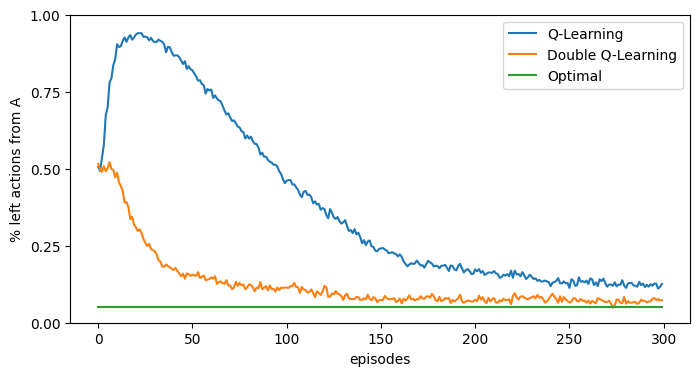

In [17]:
q, dq = run_experiment()

plt.figure(figsize=(8, 4))
plt.plot(q, label="Q-Learning")
plt.plot(dq, label="Double Q-Learning")
plt.plot([0.05] * len(q), label="Optimal")
plt.xlabel("episodes")
plt.ylabel("% left actions from A")
plt.yticks([0, 0.25, 0.50, 0.75, 1.00])
plt.legend()
plt.show()